## 对抗生成网络案例 ##


<img src="jpg/3.png" alt="FAO" width="590" >

- 判别器 : 火眼金睛，分辨出生成和真实的 <br /> 
<br /> 
- 生成器 : 瞒天过海，骗过判别器 <br /> 
<br /> 
- 损失函数定义 : 一方面要让判别器分辨能力更强，另一方面要让生成器更真 <br /> 
<br /> 

<img src="jpg/1.jpg" alt="FAO" width="590" >

In [1]:
import tensorflow as tf
import numpy as np
import pickle
import matplotlib.pyplot as plt

%matplotlib inline

# 导入数据

In [24]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/data')

Extracting /data\train-images-idx3-ubyte.gz
Extracting /data\train-labels-idx1-ubyte.gz
Extracting /data\t10k-images-idx3-ubyte.gz
Extracting /data\t10k-labels-idx1-ubyte.gz


## 网络架构

### 输入层 ：待生成图像（噪音）和真实数据

### 生成网络：将噪音图像进行生成

### 判别网络：
- （1）判断真实图像输出结果 
- （2）判断生成图像输出结果

### 目标函数：
- （1）对于生成网络要使得生成结果通过判别网络为真 
- （2）对于判别网络要使得输入为真实图像时判别为真 输入为生成图像时判别为假

<img src="jpg/2.png" alt="FAO" width="590" >

## Inputs

In [3]:
#真实数据和噪音数据
def get_inputs(real_size, noise_size):
    
    real_img = tf.placeholder(tf.float32, [None, real_size])#占位
    noise_img = tf.placeholder(tf.float32, [None, noise_size])
    
    return real_img, noise_img

## 生成器
* noise_img: 产生的噪音输入
* n_units: 隐层单元个数
* out_dim: 输出的大小（28 * 28 * 1）

In [4]:
def get_generator(noise_img, n_units, out_dim, reuse=False, alpha=0.01):
#reuse决定参数是否被重复利用
    with tf.variable_scope("generator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(noise_img, n_units)
        # leaky ReLU加入激活函数
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        # dropout
        hidden1 = tf.layers.dropout(hidden1, rate=0.2)

        # logits & outputs
        logits = tf.layers.dense(hidden1, out_dim)
        outputs = tf.tanh(logits)
        
        return logits, outputs

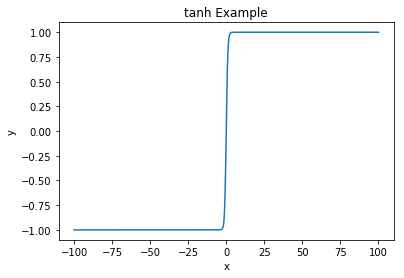

In [5]:
tf.layers.dense?
#密集连接层

tf.tanh?
#双曲正切函数
x = np.linspace(-100, 100, 1000)
y = np.tanh(x)
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("tanh Example")
plt.show()

tf.variable_scope?

## 判别器
* img：输入
* n_units：隐层单元数量
* reuse：由于要使用两次

In [6]:
def get_discriminator(img, n_units, reuse=False, alpha=0.01):

    with tf.variable_scope("discriminator", reuse=reuse):
        # hidden layer
        hidden1 = tf.layers.dense(img, n_units)
        hidden1 = tf.maximum(alpha * hidden1, hidden1)
        
        # logits & outputs
        logits = tf.layers.dense(hidden1, 1)
        outputs = tf.sigmoid(logits)
        
        return logits, outputs

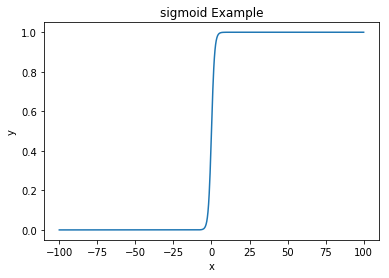

In [7]:
tf.sigmoid?
x = np.linspace(-100, 100, 1000)
y = 1/(1+np.exp(-x))
plt.plot(x,y)
plt.xlabel("x")
plt.ylabel("y")
plt.title("sigmoid Example")
plt.show()

## 网络参数定义
* img_size：输入大小
* noise_size：噪音图像大小
* g_units：生成器隐层参数
* d_units：判别器隐层参数
* learning_rate：学习率

In [8]:
img_size = mnist.train.images[0].shape[0]

noise_size = 100

g_units = 128

d_units = 128

learning_rate = 0.001

alpha = 0.01

In [9]:
print(img_size,mnist.train.images[0].shape)
print(28*28)

784 (784,)
784


## 构建网络

In [10]:
tf.reset_default_graph()#函数用于清除默认图形堆栈并重置全局默认图形.

real_img, noise_img = get_inputs(img_size, noise_size)

# generator
g_logits, g_outputs = get_generator(noise_img, g_units, img_size)

# discriminator
d_logits_real, d_outputs_real = get_discriminator(real_img, d_units)#real_img
d_logits_fake, d_outputs_fake = get_discriminator(g_outputs, d_units, reuse=True)#fake_img

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.


### 目标函数：
- （1）对于生成网络要使得生成结果通过判别网络为真 
- （2）对于判别网络要使得输入为真实图像时判别为真 输入为生成图像时判别为假

<img src="jpg/2.png" alt="FAO" width="590" >

In [11]:
# discriminator的loss
# 识别真实图片
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                     labels=tf.ones_like(d_logits_real)))
# 识别生成的图片
d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                     labels=tf.zeros_like(d_logits_fake)))
# 总体loss
d_loss = tf.add(d_loss_real, d_loss_fake)

# generator的loss
g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                                labels=tf.ones_like(d_logits_fake)))

## 优化器

In [12]:
train_vars = tf.trainable_variables()

# 取出要优化的变量
# generator
g_vars = [var for var in train_vars if var.name.startswith("generator")]
# discriminator
d_vars = [var for var in train_vars if var.name.startswith("discriminator")]

# optimizer
d_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)
g_train_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)

# 训练

In [13]:
# batch_size
batch_size = 64
# 训练迭代轮数
epochs = 300
# 抽取样本数
n_sample = 25

# 存储测试样例
samples = []
# 存储loss
losses = []
# 需要保存生成器变量
saver = tf.train.Saver(var_list = g_vars)
# 开始训练
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())#初始化变量
    for e in range(epochs):
        for batch_i in range(mnist.train.num_examples//batch_size):
            batch = mnist.train.next_batch(batch_size)
            
            batch_images = batch[0].reshape((batch_size, 784))
            # 对图像像素进行scale，这是因为tanh输出的结果介于(-1,1),real和fake图片共享
            #discriminator的参数
            batch_images = batch_images*2 - 1
            
            # generator的输入噪声
            # 从一个均匀分布[low,high)中随机采样，注意定义域是左闭右开
            batch_noise = np.random.uniform(-1, 1, size=(batch_size, noise_size))
            
            # Run optimizers
            _ = sess.run(d_train_opt, feed_dict={real_img: batch_images, noise_img: batch_noise})
            _ = sess.run(g_train_opt, feed_dict={noise_img: batch_noise})
        
        # 每一轮结束计算loss
        #总体判别器的损失
        train_loss_d = sess.run(d_loss, feed_dict = {real_img: batch_images, 
                                                     noise_img: batch_noise})
        #判别器
        # real img loss
        train_loss_d_real = sess.run(d_loss_real, feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        # fake img loss
        train_loss_d_fake = sess.run(d_loss_fake, feed_dict = {real_img: batch_images, 
                                                 noise_img: batch_noise})
        
        # generator loss
        train_loss_g = sess.run(g_loss, feed_dict = {noise_img: batch_noise})
        
         
        if e%50 == 0:
            print("Epoch {}/{}...".format(e+1, epochs), "判别器损失: {:.4f}(判别真实的: {:.4f} + 判别生成的: {:.4f})..."
                  .format(train_loss_d, train_loss_d_real,  train_loss_d_fake), "生成器损失: {:.4f}".format(train_loss_g))    
        
        losses.append((train_loss_d, train_loss_d_real, train_loss_d_fake, train_loss_g))
        
        # 保存样本,做一些显示示例
        sample_noise = np.random.uniform(-1, 1, size=(n_sample, noise_size))
        gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                               feed_dict={noise_img: sample_noise})
        samples.append(gen_samples)
        
        #保存模型
        saver.save(sess, './checkpoints/generator.ckpt')

# 将生成的样例保存到本地
with open('train_samples.pkl', 'wb') as f:
    pickle.dump(samples, f)

Epoch 1/300... 判别器损失: 0.0158(判别真实的: 0.0020 + 判别生成的: 0.0138)... 生成器损失: 4.3024
Epoch 51/300... 判别器损失: 0.8686(判别真实的: 0.4300 + 判别生成的: 0.4386)... 生成器损失: 1.3807
Epoch 101/300... 判别器损失: 0.9928(判别真实的: 0.4794 + 判别生成的: 0.5134)... 生成器损失: 1.2468
Epoch 151/300... 判别器损失: 1.0553(判别真实的: 0.3982 + 判别生成的: 0.6571)... 生成器损失: 1.2728
Epoch 201/300... 判别器损失: 0.8717(判别真实的: 0.3511 + 判别生成的: 0.5206)... 生成器损失: 1.4142
Epoch 251/300... 判别器损失: 0.8474(判别真实的: 0.5598 + 判别生成的: 0.2876)... 生成器损失: 2.1783


# loss迭代曲线

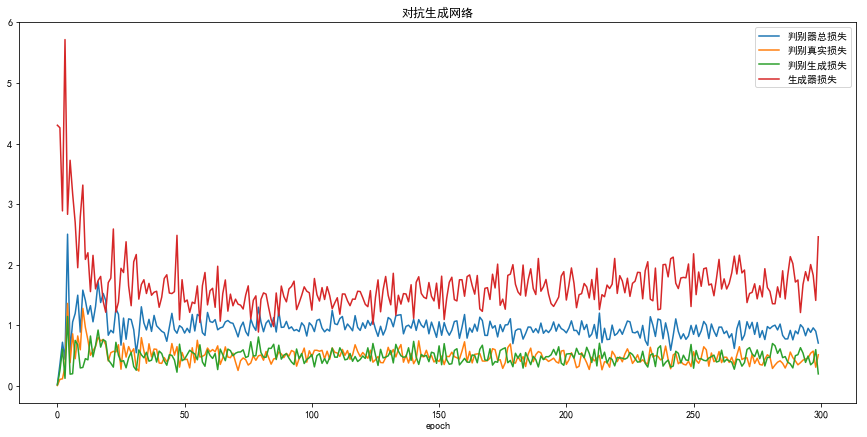

In [14]:
plt.rcParams['font.sans-serif'] = ['Simhei']#解决中文乱码问题
fig, ax = plt.subplots(figsize=(15,7))
losses = np.array(losses)
plt.plot(losses.T[0], label='判别器总损失')
plt.plot(losses.T[1], label='判别真实损失')
plt.plot(losses.T[2], label='判别生成损失')
plt.plot(losses.T[3], label='生成器损失')
plt.title("对抗生成网络")
ax.set_xlabel('epoch')
plt.legend()
plt.show()

# 生成结果

In [15]:
# Load samples from generator taken while training
with open('train_samples.pkl', 'rb') as f:
    samples = pickle.load(f)

In [16]:
len(samples)

300

In [17]:
#samples是保存的结果 epoch是第多少次迭代
def view_samples(epoch, samples):
    
    fig, axes = plt.subplots(figsize=(10,10), nrows=5, ncols=5, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch][1]): 
        # 这里samples[epoch][1]代表生成的图像结果，而[0]代表对应的logits
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    
    return fig, axes

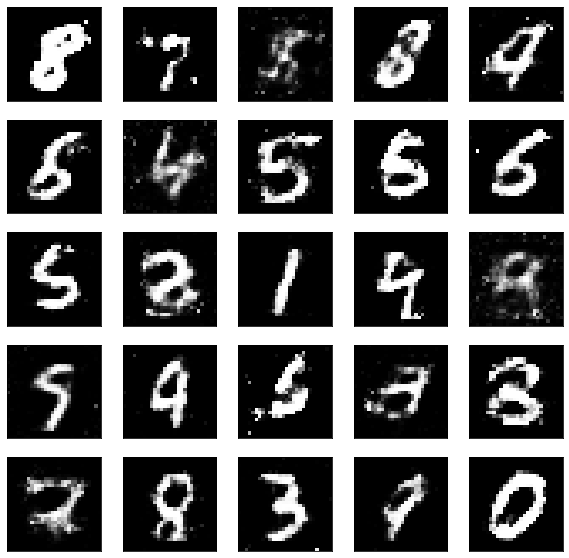

In [18]:
_ = view_samples(-1, samples) # 显示最后一个epoch的生成结果（生成了25个样本）

# 显示整个生成过程图片

In [19]:
# 指定要查看的轮次
epoch_idx = np.arange(0,299,30) 
show_imgs = []
for i in epoch_idx:
    show_imgs.append(samples[i][1])

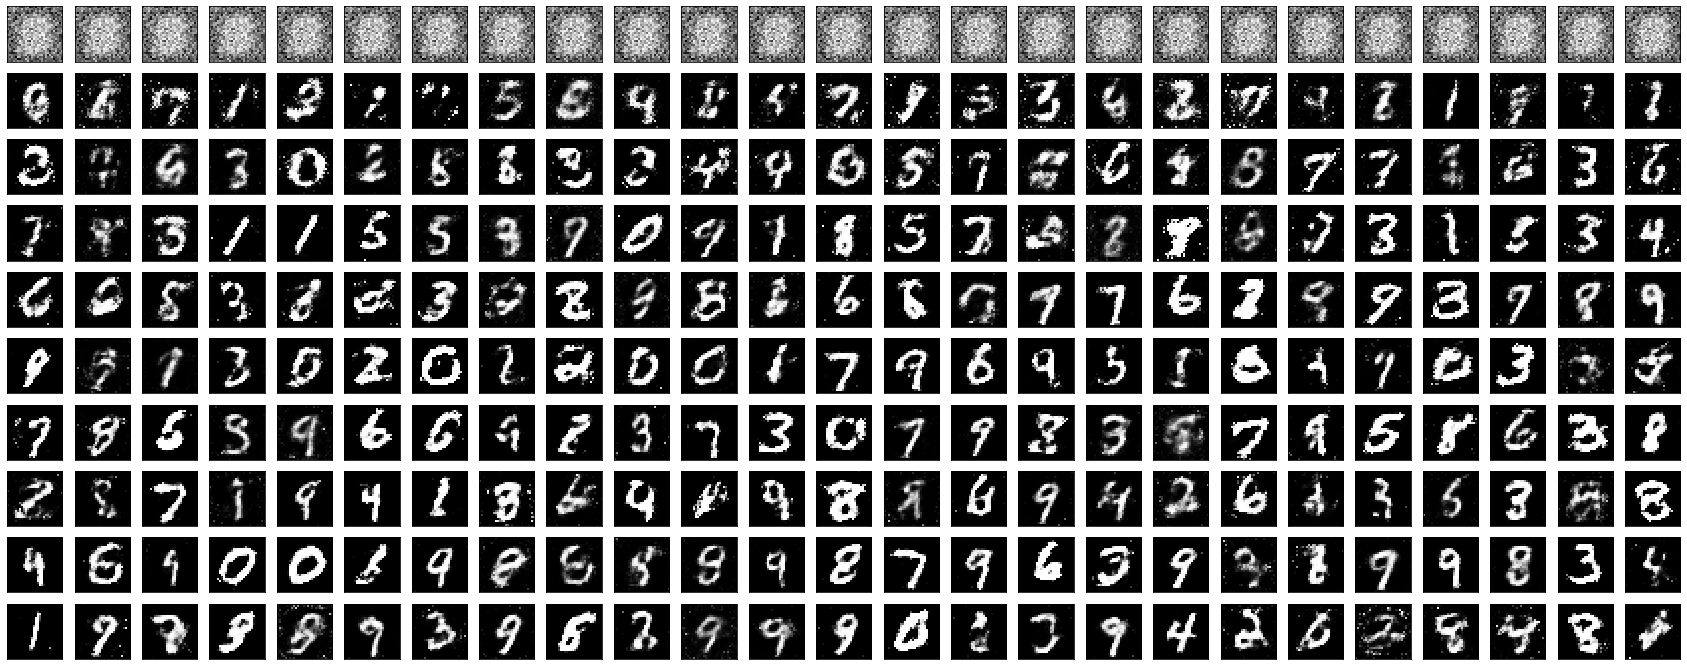

In [20]:
# 指定图片形状
rows, cols = 10, 25
fig, axes = plt.subplots(figsize=(30,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

idx = range(0, epochs, int(epochs/rows))

for sample, ax_row in zip(show_imgs, axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

# 生成新的图片

In [21]:
# 加载我们的生成器变量
saver = tf.train.Saver(var_list=g_vars)
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    sample_noise = np.random.uniform(-1, 1, size=(25, noise_size))
    gen_samples = sess.run(get_generator(noise_img, g_units, img_size, reuse=True),
                           feed_dict={noise_img: sample_noise})


Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoints\generator.ckpt


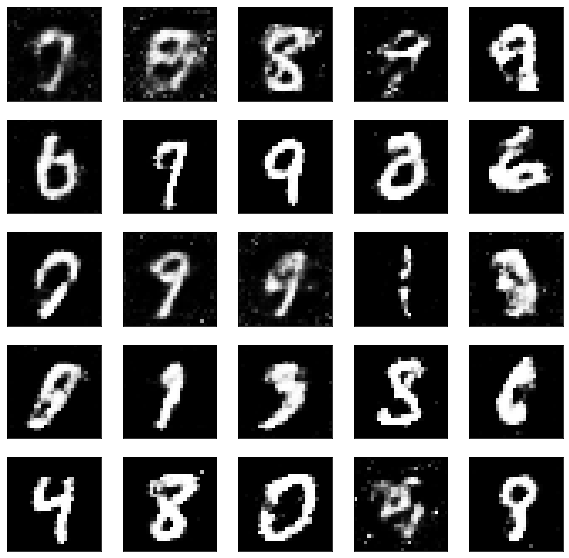

In [22]:
_ = view_samples(0, [gen_samples])

In [23]:
np.arange(5,50,10)

array([ 5, 15, 25, 35, 45])